In [1]:
import os
import wbgapi as wb
import pandas as pd
import requests
import xml.etree.ElementTree as ET

In [2]:
#pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
import ydata_profiling

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Carga de índices y lista de paises
# Ruta completa del archivo Excel
ruta_lista_ods = r"C:\Users\Usuario\Downloads\CEPAL\Sustainable_Development_Goals.xlsx"
ruta_lista_devg = r"C:\Users\Usuario\Downloads\CEPAL\Codigos_Indicadores_Desarrollo.xlsx"

# Carga el archivo Excel en un DataFrame de pandas
df_ods = pd.read_excel(ruta_lista_ods)
df_devg = pd.read_excel(ruta_lista_devg)

# Ahora 'df' contiene los datos del archivo Excel
list_ods_id = df_ods["Series Code"].dropna().tolist()
list_devg_id = df_devg["Series Code"].dropna().tolist()

# Valores a eliminar
valores_a_eliminar = ["SL.ISV.IFRM.ZS", "SL.ISV.IFRM.FE.ZS", "SL.ISV.IFRM.MA.ZS"]

# Crea una nueva lista excluyendo los valores a eliminar
list_ods_id = [valor for valor in list_ods_id if valor not in valores_a_eliminar]

# Lista de países
countries = ["ARG", "BHS", "BRB", "BOL", "BRA", "CAN", "COL", "CRI", "CUB", "CHL", "ECU", "SLV", "USA", "FRA", "GRD", "GTM", "GUY", "HTI", "HND", "JAM", "MEX", "NIC", "NLD", "PAN", "PRY", "PER", "GBR", "DOM", "SUR", "TTO", "URY", "VEN"]

#len(list_ods_id)

In [4]:
###########Carga o descarga de dataset de objetivos de desarrollo sostenible mediante libreria API del banco mundial

# Ruta donde deseas guardar el archivo Excel
ruta_guardado_ods = r"C:\Users\Usuario\Downloads\CEPAL\ods_raw.xlsx"

# Verifica si el archivo 'corr_raw.xlsx' existe en el directorio
if os.path.exists(ruta_guardado_ods):
    # Si el archivo existe, carga el DataFrame desde el archivo Excel
    ods_raw_df = pd.read_excel(ruta_guardado_ods)
else:
    # Si el archivo no existe, realiza la conexión a la base de datos de wb y crea el diccionario de DataFrames
    dfs_ods = {}

    # Ciclo para crear dataframes para cada indicador
    for series_code in list_ods_id:
        # Crea un dataframe para el indicador actual
        df = wb.data.DataFrame(
            series_code,
            countries,
            index="time",
            numericTimeKeys=True,
            labels=True
        )

        # Genera un nombre en la notación "id_ODS"
        dataframe_name = f"{series_code}_ODS"

        # Agrega el DataFrame al diccionario usando el nombre generado como clave
        dfs_ods[dataframe_name] = df

    # Inicializa una lista para almacenar los DataFrames concatenados
    concat_ods_dfs = []

    # Recorre el diccionario dfs_ods
    for dataframe_name, df in dfs_ods.items():
        # Agrega una columna 'series_code' con el valor correspondiente
        df['series_code'] = dataframe_name.split('_')[0]  # Obtiene el series_code a partir del nombre
        # Agrega el DataFrame actual a la lista
        concat_ods_dfs.append(df)

    # Concatena todos los DataFrames en uno solo
    ods_raw_df = pd.concat(concat_ods_dfs, ignore_index=True)

    # Mueve la columna 'series_code' al primer lugar
    ods_raw_df.insert(0, 'series_code', ods_raw_df.pop('series_code'))

    # Guarda el DataFrame como un archivo Excel en la ubicación especificada
    ods_raw_df.to_excel(ruta_guardado_ods, index=False)
    
    

###########Carga o descarga de dataset de objetivos de desarrollo global mediante libreria API del banco mundial

# Ruta donde deseas guardar el archivo Excel
ruta_guardado_devg = r"C:\Users\Usuario\Downloads\CEPAL\devg_raw.xlsx"

# Verifica si el archivo 'corr_raw.xlsx' existe en el directorio
if os.path.exists(ruta_guardado_devg):
    # Si el archivo existe, carga el DataFrame desde el archivo Excel
    devg_raw_df = pd.read_excel(ruta_guardado_devg)
else:
    # Diccionario para almacenar los DataFrames
    dfs_devg = {}

    # Ciclo para crear dataframes para cada indicador
    for series_code in list_devg_id:
        # Crea un dataframe para el indicador actual
        df = wb.data.DataFrame(
            series_code,
            countries,
            index="time",
            numericTimeKeys=True,
            labels=True
        )

        # Genera un nombre en la notación "id_ODS"
        dataframe_name = f"{series_code}_DEVG"

        # Agrega el DataFrame al diccionario usando el nombre generado como clave
        dfs_devg[dataframe_name] = df

        # Inicializa una lista para almacenar los DataFrames concatenados
        concat_devg_dfs = []

    # Recorre el diccionario dfs_ods
    for dataframe_name, df in dfs_devg.items():
        # Agrega una columna 'series_code' con el valor correspondiente
        df['series_code'] = dataframe_name.split('_')[0]  # Obtiene el series_code a partir del nombre
        # Agrega el DataFrame actual a la lista
        concat_devg_dfs.append(df)

    # Concatena todos los DataFrames en uno solo
    devg_raw_df = pd.concat(concat_devg_dfs, ignore_index=True)

    # Mueve la columna 'series_code' al primer lugar
    devg_raw_df.insert(0, 'series_code', devg_raw_df.pop('series_code'))

    # Guarda el DataFrame como un archivo Excel en la ubicación especificada
    devg_raw_df.to_excel(ruta_guardado_devg, index=False)
    
    
    
###########Carga o descarga de dataset de indicadores de corrupción mediante libreria API del banco mundial

# Ruta donde deseas guardar el archivo Excel
ruta_guardado_corr = r"C:\Users\Usuario\Downloads\CEPAL\corr_raw.xlsx"
  
#extraer lista de indicadores de corrupción
# URL del documento XML
url = "https://api.worldbank.org/v2/sources/3/indicators"

# Realiza una solicitud HTTP para obtener el contenido del enlace
response = requests.get(url)

# Verifica si la solicitud fue exitosa (código de respuesta 200)
if response.status_code == 200:
    # Parsea el contenido XML
    xml_content = response.content
    root = ET.fromstring(xml_content)

    # Inicializa una lista para almacenar los elementos 'indicator'
    list_corr_id = []

    # Itera a través de los elementos 'indicator' en el árbol XML
    for indicator in root.findall(".//wb:indicator", namespaces={"wb": "http://www.worldbank.org"}):
        # Obtiene el valor del atributo 'id' y el texto dentro del elemento 'wb:name'
        indicator_id = indicator.get("id")
        indicator_name = indicator.find("wb:name", namespaces={"wb": "http://www.worldbank.org"}).text

        # Almacena los datos en un diccionario
        indicator_data = {
            "id": indicator_id,
            "name": indicator_name
        }

        # Agrega el diccionario a la lista de indicadores
        list_corr_id.append(indicator_data)

# Código para obtener indicadores adicionales si es necesario
# ...

# Verifica si el archivo 'corr_raw.xlsx' existe en el directorio
if os.path.exists(ruta_guardado_corr):
    # Si el archivo existe, carga el DataFrame desde el archivo Excel
    corr_raw_df = pd.read_excel(ruta_guardado_corr)
else:

        dfs_corr = {}

        # Ciclo para crear dataframes para cada indicador
        for indicator_data in list_corr_id:
            indicator_id = indicator_data["id"]

            # Crea un dataframe para el indicador actual
            df = wb.data.DataFrame(
                indicator_id,
                countries,
                index="time",
                numericTimeKeys=True,
                labels=True
            )

            # Genera un nombre en la notación "id_cepal"
            dataframe_name = f"{indicator_id}_CORR"

            # Agrega el DataFrame al diccionario usando el nombre generado como clave
            dfs_corr[dataframe_name] = df

        # Inicializa una lista para almacenar los DataFrames concatenados
        concat_corr_dfs = []

        # Recorre el diccionario dfs_corr
        for dataframe_name, df in dfs_corr.items():
            # Agrega una columna 'series_code' con el valor correspondiente
            df['series_code'] = dataframe_name.split('_')[0]  # Obtiene el series_code a partir del nombre
            # Agrega el DataFrame actual a la lista
            concat_corr_dfs.append(df)

        # Concatena todos los DataFrames en uno solo
        corr_raw_df = pd.concat(concat_corr_dfs, ignore_index=True)

        # Mueve la columna 'series_code' al primer lugar
        corr_raw_df.insert(0, 'series_code', corr_raw_df.pop('series_code'))

        # Guarda el DataFrame como un archivo Excel en la ubicación especificada
        corr_raw_df.to_excel(ruta_guardado_corr, index=False)

In [5]:
# Lista para almacenar los nuevos DataFrames sin filas de NaN
clnd_dfs = []

raw_dfs = [ods_raw_df, devg_raw_df, corr_raw_df]

for df in raw_dfs:
    # Copia el DataFrame original para mantenerlo intacto
    nuevo_df = df.copy()
    
    # Guarda las filas eliminadas en otro DataFrame
    filas_eliminadas = nuevo_df[nuevo_df.iloc[:, 2:34].isnull().all(axis=1)]
    
    ## Elimina las filas con todos los valores NaN
    nuevo_df.dropna(subset=nuevo_df.columns[2:34], how='all', inplace=True)
    
    # Agrega el nuevo DataFrame a la lista de nuevos DataFrames
    clnd_dfs.append(nuevo_df)
    
#######paises
## Diccionario para almacenar los resultados
nan_info_dict = {}

# Itera a través de la lista de DataFrames sin filas de NaN (clnd_dfs)
for i, df in enumerate(clnd_dfs):
    # Calcula la cantidad de datos NaN por cada columna en el DataFrame
    nan_count_per_column = df.isna().sum()
    
    # Calcula el porcentaje de datos perdidos en cada columna
    total_rows = len(df)
    nan_percentage_per_column = (nan_count_per_column / total_rows) * 100
    
    # Almacena la información en un DataFrame
    nan_info_df = pd.DataFrame({
        "NaN_Count": nan_count_per_column,
        "NaN_Percentage": nan_percentage_per_column
    })
    
    # Ordena el DataFrame por la columna "NaN_Count" en orden descendente
    nan_info_df = nan_info_df.sort_values(by="NaN_Count", ascending=False)
    
    # Agrega el DataFrame con la información al diccionario
    nan_info_dict[f"clean_{i + 1}"] = nan_info_df

# Obtener el DataFrame correspondiente a clean_ods_df en nan_info_dict (por índice)
nan_info_clean_ods = list(nan_info_dict.values())[0]

#### Filtrar las columnas con porcentaje superior al 26.0
columns_to_exclude = nan_info_clean_ods[nan_info_clean_ods["NaN_Percentage"] > 26.0].index.tolist()

# Eliminar las columnas coincidentes de los dos primeros DataFrames en clnd_dfs
for i in range(2):
    clnd_dfs[i] = clnd_dfs[i].drop(columns=columns_to_exclude)

# Crear el nuevo DataFrame excluded_corr a partir de clnd_dfs[2]
excluded_corr = clnd_dfs[2][columns_to_exclude]

# Eliminar las columnas coincidentes de clnd_dfs[2]
clnd_dfs[2] = clnd_dfs[2].drop(columns=columns_to_exclude)

# Almacenar los DataFrames en sus variables originales (opcional)
clnd_dfs.append(excluded_corr)

##########indicadores

# Diccionario para almacenar los porcentajes de NaN por DataFrame
nan_percentage_dict = {}

# Itera a través de la lista de DataFrames en clnd_dfs
for i, df in enumerate(clnd_dfs[:3]):
    # Obtiene los valores únicos en la columna "series_code"
    unique_series_codes = df["series_code"].unique()

    # Diccionario para almacenar los porcentajes de NaN por DataFrame filtrado
    nan_percentage_per_series = {}

    # Filtra el DataFrame por cada valor único en "series_code" y calcula el porcentaje de NaN
    for series_code in unique_series_codes:
        filtered_df = df[df["series_code"] == series_code]
        nan_percentage = (filtered_df.isna().sum().sum() / filtered_df.size) * 100
        nan_percentage_per_series[series_code] = nan_percentage

    # Almacena el diccionario de porcentajes de NaN en el diccionario principal
    nan_percentage_dict[f"clean_{i + 1}"] = nan_percentage_per_series

# Resultado: nan_percentage_dict contendrá los porcentajes de NaN para cada DataFrame filtrado en clnd_dfs

# Crear listas de series_code que tengan un porcentaje superior a 26.0 en los tres primeros DataFrames de clnd_dfs
series_codes_to_exclude = set()

# Iterar a través de los primeros tres DataFrames en clnd_dfs
for i in range(3):
    for series_code, nan_percentage in nan_percentage_dict[f"clean_{i + 1}"].items():
        if nan_percentage > 26.0:
            series_codes_to_exclude.add(series_code)

# Filtrar las filas correspondientes de los tres primeros DataFrames en clnd_dfs
for i in range(3):
    clnd_dfs[i] = clnd_dfs[i][~clnd_dfs[i]["series_code"].isin(series_codes_to_exclude)]

# Ahora clnd_dfs contiene los DataFrames sin las filas con series_code con porcentaje superior a 26.0 en los tres primeros DataFrames



#######años

# Diccionario para almacenar los porcentajes de NaN por DataFrame
nan_percentage_dict = {}

# Itera a través de la lista de DataFrames en clnd_dfs
for i, df in enumerate(clnd_dfs[:3]):
    # Obtiene los valores únicos en la columna "Year"
    unique_years = df["Time"].unique()

    # Diccionario para almacenar los porcentajes de NaN por DataFrame filtrado
    nan_percentage_per_year = {}

    # Filtra el DataFrame por cada valor único en "Year" y calcula el porcentaje de NaN
    for year in unique_years:
        filtered_df = df[df["Time"] == year]
        nan_percentage = (filtered_df.isna().sum().sum() / filtered_df.size) * 100
        nan_percentage_per_year[year] = nan_percentage

    # Almacena el diccionario de porcentajes de NaN en el diccionario principal
    nan_percentage_dict[f"clean_{i + 1}"] = nan_percentage_per_year

# Resultado: nan_percentage_dict contendrá los porcentajes de NaN para cada DataFrame filtrado en clnd_dfs


# Crear una lista para almacenar los años con porcentaje superior a 26.0
years_to_exclude = []

# Iterar a través del nan_percentage_dict
for i in range(3):
    nan_percentage_per_year = nan_percentage_dict[f"clean_{i + 1}"]
    for year, nan_percentage in nan_percentage_per_year.items():
        if nan_percentage > 26.0 and year not in years_to_exclude:
            years_to_exclude.append(year)

# Eliminar las filas correspondientes de los tres primeros DataFrames en clnd_dfs
for i in range(3):
    clnd_dfs[i] = clnd_dfs[i][~clnd_dfs[i]["Time"].isin(years_to_exclude)]
    
# Iterar a través de los primeros tres DataFrames en clnd_dfs
for i in range(3):
    df = clnd_dfs[i]  # Obtén el DataFrame actual
    unique_series_codes = df["series_code"].unique()  # Obtiene los valores únicos en "series_code"

    # Iterar a través de los valores únicos en "series_code"
    for series_code in unique_series_codes:
        # Filtra el DataFrame por el valor único en "series_code" y copia el resultado
        filtered_df = df[df["series_code"] == series_code].copy()
        
        # Calcula la mediana por columna en el subconjunto de datos y reemplaza NaN por la mediana
        median_values = filtered_df.median(numeric_only=True)  # Calcula la mediana por columna
        filtered_df.fillna(median_values, inplace=True)  # Reemplaza NaN por la mediana en el DataFrame copiado

        # Actualiza el DataFrame original con los valores reemplazados
        df.update(filtered_df)

# Ahora, clnd_dfs contiene los DataFrames originales con los valores NaN reemplazados por las medianas correspondientes en cada serie_code




In [6]:
#guardar dataframes consolidado de indicadores
clean_ods_df = clnd_dfs[0]  # Primer DataFrame en la lista
clean_devg_df = clnd_dfs[1]  # Segundo DataFrame en la lista
clean_corr_df = clnd_dfs[2]  # Tercer DataFrame en la lista

# Crea un diccionario con los nombres de los DataFrames y los nombres de archivo correspondientes
dataframes_dict = {
    "clean_ods": clean_ods_df,
    "clean_devg": clean_devg_df,
    "clean_corr": clean_corr_df
}

# Define la ruta de guardado con un nombre de archivo (reemplaza [nombre_archivo] con el nombre deseado)
ruta_guardado_base = r"C:\Users\Usuario\Downloads\CEPAL\nombre_archivo.xlsx"

# Itera sobre el diccionario y verifica si los archivos ya existen
for nombre_df, df in dataframes_dict.items():
    # Genera la ruta completa del archivo Excel
    ruta_guardado = ruta_guardado_base.replace("nombre_archivo", nombre_df)
    
    # Verifica si el archivo ya existe en el directorio
    if os.path.exists(ruta_guardado):
        # Si el archivo existe, carga el DataFrame desde el archivo Excel
        df_loaded = pd.read_excel(ruta_guardado)
        
        # Puedes asignar df_loaded a una variable específica si es necesario
        # Por ejemplo, si quieres reemplazar el DataFrame original
        # clean_ods_df = df_loaded

        ##print(f"El archivo {ruta_guardado} ya existe. Cargando DataFrame...")
    else:
        # Si el archivo no existe, guarda el DataFrame como un archivo Excel
        df.to_excel(ruta_guardado, index=False)
        ##print(f"Guardando DataFrame en {ruta_guardado}")

##print("Operación completada.")

In [7]:
def create_filtered_dataframes(original_df):
    # Obtiene los valores únicos de la columna 'series_code'
    unique_series_codes = original_df['series_code'].unique()

    # Diccionario para almacenar los nuevos DataFrames
    new_dfs = {}

    for series_code in unique_series_codes:
        
        original_df['Time'] = original_df['Time'].astype(int)
        
        
        # Filtra el DataFrame original por 'series_code'
        filtered_df = original_df[original_df['series_code'] == series_code]
        
        
        # Obtén los nombres de las columnas en lugar de los valores de la columna "Time"
        nombres_columnas = list(filtered_df.columns[2:])
        
        # Crear un DataFrame para almacenar datos
        transposed_df = pd.DataFrame()
        
        for country in nombres_columnas:
            
            slide_df = pd.DataFrame()
            slide_df["Year"] = filtered_df['Time']
            slide_df[series_code] = filtered_df[country]
            slide_df["Country"] = country

            # Reorganizar las columnas
            slide_df = slide_df[['Country', 'Year', series_code]]

            # Utiliza el método concat para agregar slide_df a transposed_df
            transposed_df = pd.concat([transposed_df, slide_df], ignore_index=True)
                                      
        # Almacena el DataFrame transpuesto en el diccionario new_dfs
        new_dfs[series_code] = transposed_df

    return new_dfs

dataframe_dict1 = create_filtered_dataframes(clean_corr_df)
dataframe_dict2 = create_filtered_dataframes(clean_ods_df)
dataframe_dict3 = create_filtered_dataframes(clean_devg_df)

In [8]:
# Función para unir DataFrames y devolver el DataFrame resultante
def merge_dataframes(dataframe_dict):
    # Inicializa el DataFrame resultante con las primeras 2 columnas
    result_df = pd.DataFrame({'Country': [], 'Year': []})
    
    # Realiza una unión externa (outer join) de todos los DataFrames en el diccionario
    for series_code, df in dataframe_dict.items():
        result_df = pd.merge(result_df, df, on=['Country', 'Year'], how='outer')
    
    # Reordena las columnas para tener 'Country' y 'Year' al principio
    result_columns = ['Country', 'Year'] + [col for col in result_df.columns if col not in ['Country', 'Year']]
    result_df = result_df[result_columns]
    
    # Devuelve el DataFrame resultante
    return result_df

# Llama a la función para unir DataFrames y obtener el resultado
result_df1 = merge_dataframes(dataframe_dict1)
result_df2 = merge_dataframes(dataframe_dict2)
result_df3 = merge_dataframes(dataframe_dict3)



####
# Obtener la lista de valores únicos en la columna 'Year' de result_df1
unique_years = result_df1['Year'].unique()

# Filtrar result_df2 y result_df3 para que solo contengan los valores coincidentes en la columna 'Year'
result_df2 = result_df2[result_df2['Year'].isin(unique_years)]
result_df3 = result_df3[result_df3['Year'].isin(unique_years)]
# Elimina las columnas desde la posición 3 hasta 12 (índice 3 al 12) en result_df2
result_df2 = result_df2.drop(result_df2.columns[2:11], axis=1)

####
columns_to_remove_corr = [
    'CC.NO.SRC', 'CC.PER.RNK.LOWER', 'CC.PER.RNK.UPPER', 'CC.STD.ERR', 'CC.PER.RNK',
    'GE.NO.SRC', 'GE.PER.RNK.LOWER', 'GE.PER.RNK.UPPER', 'GE.STD.ERR', 'GE.PER.RNK',
    'PV.NO.SRC', 'PV.PER.RNK.LOWER', 'PV.PER.RNK.UPPER', 'PV.STD.ERR', 'PV.PER.RNK',
    'RQ.NO.SRC', 'RQ.PER.RNK.LOWER', 'RQ.PER.RNK.UPPER', 'RQ.STD.ERR', 'RL.PER.RNK',
    'RL.NO.SRC', 'RL.PER.RNK.LOWER', 'RL.PER.RNK.UPPER', 'RL.STD.ERR', 'RQ.PER.RNK',
    'VA.NO.SRC', 'VA.PER.RNK.LOWER', 'VA.PER.RNK.UPPER', 'VA.STD.ERR', 'VA.PER.RNK'
]

result_df1 = result_df1.drop(columns=columns_to_remove_corr)



columns_to_remove_ods = [
    'FB.CBK.BRCH.P5', 'SL.GDP.PCAP.EM.KD'
]

result_df2 = result_df2.drop(columns=columns_to_remove_ods)



columns_to_remove_devg = [
    'BX.KLT.DINV.WD.GD.ZS', 'BM.KLT.DINV.WD.GD.ZS', 'NY.GDP.MKTP.KD.ZG', 'NY.GDP.PCAP.KD', 'NY.GDP.PCAP.CD',
    'SL.UEM.TOTL.ZS', 'SL.UEM.1524.ZS'
]

result_df3 = result_df3.drop(columns=columns_to_remove_devg)

####
# Función para reemplazar NaN por la mediana de cada columna dentro de cada grupo 'Country'
def replace_nan_with_column_median(df):
    return df.fillna(df.median(numeric_only=True))

# Función para procesar un DataFrame
def process_dataframe(df):
    # Filtrar por cada elemento de la columna 'Country' y reemplazar los NaN por la mediana de cada columna
    df = df.groupby('Country').apply(replace_nan_with_column_median)
    
    # Reemplazar los valores faltantes restantes con cero en todo el DataFrame
    df.fillna(0, inplace=True)
    
    # Reiniciar los índices después del groupby
    df = df.reset_index(drop=True)
    
    return df

# Supongamos que result_df2 y result_df3 son tus DataFrames con NaN
result_df2 = process_dataframe(result_df2)
result_df3 = process_dataframe(result_df3)

####
# Función para ordenar un DataFrame por 'Country' en orden alfabético y 'Year' en orden descendente
def sort_dataframe(df):
    return df.sort_values(by=['Country', 'Year'], ascending=[True, False])

# Supongamos que result_df1, result_df2 y result_df3 son tus DataFrames

result_df1 = sort_dataframe(result_df1)
result_df2 = sort_dataframe(result_df2)
result_df3 = sort_dataframe(result_df3)


main_subset = result_df1.iloc[:, :2]

# Extraer solo las dos primeras columnas de result_df2
result_df1_subset = result_df1.iloc[:, 2:]

# Extraer solo las dos primeras columnas de result_df2
result_df2_subset = result_df2.iloc[:, 2:]

# Extraer solo las dos primeras columnas de result_df3
result_df3_subset = result_df3.iloc[:, 2:]



# Agregar prefijo a las columnas de result_df1
result_df1_subset = result_df1_subset.add_prefix("CRP_")

# Agregar prefijo a las columnas de result_df2
result_df2_subset = result_df2_subset.add_prefix("ODS_")

# Agregar prefijo a las columnas de result_df3
result_df3_subset = result_df3_subset.add_prefix("GDE_")







KeyError: "['FB.CBK.BRCH.P5'] not found in axis"

In [35]:
### transformación para análisis de datos
# Supongamos que tienes un DataFrame llamado merged_df

# Concatenar las dos primeras columnas de los tres DataFrames en uno solo
merged_df = pd.concat([main_subset,result_df1_subset, result_df2_subset, result_df3_subset], axis=1)

# Lista de nombres de las columnas desde la tercera columna en adelante
columnas_a_normalizar = merged_df.columns[2:]

# Realizar el Escalamiento Min-Max
for columna in columnas_a_normalizar:
    min_valor = merged_df[columna].min()
    max_valor = merged_df[columna].max()
    merged_df[columna] = (merged_df[columna] - min_valor) / (max_valor - min_valor)
    
# Crear diccionario de agrupación por cercanía geográfica
geographical_groups = {
    "América del Norte": ["USA", "CAN"],
    "América del Sur": ["ARG", "BHS", "BRB", "BOL", "BRA", "COL", "CRI", "CUB", "CHL", "ECU", "SLV", "GRD", "GTM", "GUY", "HTI", "HND", "JAM", "MEX", "NIC", "PAN", "PRY", "PER", "SUR", "TTO", "URY", "VEN"],
    #"Centro America": ["CRI", "SLV", "NIC","PAN","MEX","HON"..........],
    "Europa": ["FRA", "GBR", "NLD"],
    "Otras Regiones": ["DOM"]
}

# Crear una columna "Grupo Geográfico"
merged_df['Region'] = merged_df['Country'].map({country: group for group, countries in geographical_groups.items() for country in countries})

# Crear un diccionario de subregiones de América Latina
subregiones_latinoamerica = {
    "América del Norte": ["USA", "CAN"],
    "Europa": ["FRA", "GBR", "NLD"],
    "Otras Regiones": ["DOM"],
    "LA-Cono Sur": ["ARG", "CHL", "URY", "PAR"],
    "LA-Región Andina": ["COL", "ECU", "PER", "BOL"],
    "LA-Región Amazónica": ["BRA", "VEN", "GUY"],
    "LA-Región del Caribe": ["VEN", "COL", "GUY"]
}

# Crear una columna "Subregión de América Latina"
merged_df['Subregion'] = merged_df['Country'].map({country: subregion for subregion, countries in subregiones_latinoamerica.items() for country in countries})

# Reorganizar las columnas para poner las nuevas al principio
merged_df = merged_df[['Country', 'Region', 'Subregion'] + [col for col in merged_df.columns if col not in ['Country', 'Region', 'Subregion']]]






NameError: name 'main_subset' is not defined

In [36]:
import pandas as pd
import pandas as pd

# Excluir la columna 'Year' para el cálculo del promedio por país
promedio_por_pais = merged_df.drop(columns=['Year']).groupby('Country').mean().reset_index()

# Calcular el promedio por región
promedio_por_region = merged_df.drop(columns=['Year']).groupby('Region').mean().reset_index()

# Calcular el promedio por subregión
promedio_por_subregion = merged_df.drop(columns=['Year']).groupby('Subregion').mean().reset_index()

# Calcular el promedio general excluyendo la columna 'Year'
promedio_general = merged_df.drop(columns=['Year']).mean().to_frame('Promedio General').T

# Filtrar los datos para el país Colombia (COL)
datos_colombia = merged_df[merged_df['Country'] == 'COL']

# Calcular el promedio para Colombia, excluyendo la columna 'Year'
promedio_colombia = datos_colombia.drop(columns=['Year']).mean().to_frame('Promedio Colombia').T

# Visualizar el DataFrame con el promedio para Colombia
print(promedio_colombia)

# Visualizar el DataFrame con los promedios por país
print(promedio_por_pais)

# Visualizar el DataFrame con los promedios por región
print(promedio_por_region)

# Visualizar el DataFrame con los promedios por subregión
print(promedio_por_subregion)



NameError: name 'merged_df' is not defined

In [37]:
# Visualizar el DataFrame con el promedio para Colombia
#print(promedio_colombia)

# Visualizar el DataFrame con los promedios por país
#print(promedio_por_pais)

# Visualizar el DataFrame con los promedios por región
#print(promedio_por_region)

# Visualizar el DataFrame con los promedios por subregión
print(promedio_por_subregion)


NameError: name 'promedio_por_subregion' is not defined

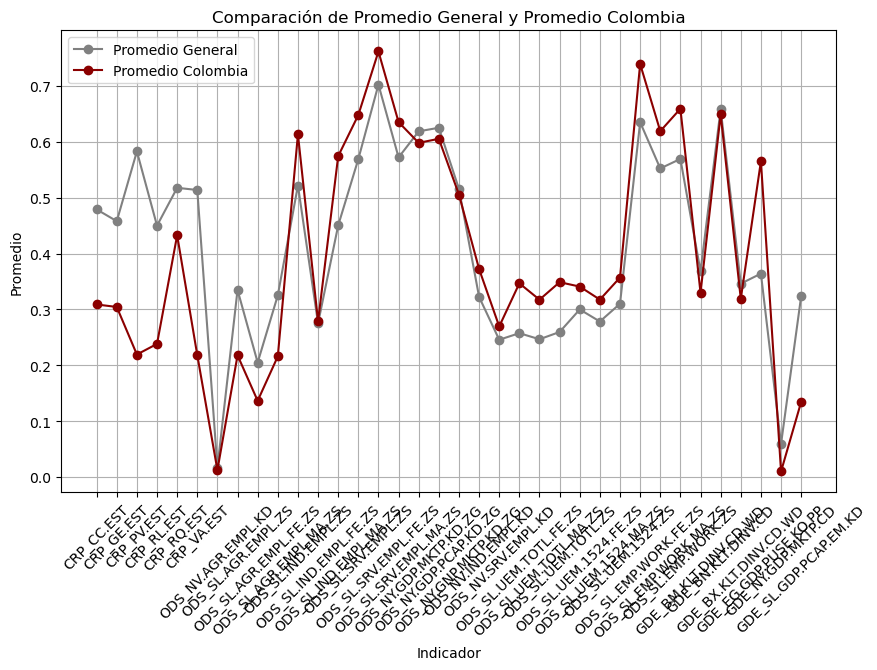

In [12]:
import matplotlib.pyplot as plt
# Crear un gráfico de líneas
plt.figure(figsize=(10, 6))

# Dibujar el gráfico de líneas para el promedio general
plt.plot(promedio_general.columns, promedio_general.iloc[0], label='Promedio General', linestyle='-', marker='o', color='gray')

# Dibujar el gráfico de líneas para el promedio de Colombia en rojo oscuro
plt.plot(promedio_colombia.columns, promedio_colombia.iloc[0], label='Promedio Colombia', linestyle='-', marker='o', color='darkred')

# Configuraciones de estilo y etiquetas
plt.xticks(rotation=45)
plt.title('Comparación de Promedio General y Promedio Colombia')
plt.xlabel('Indicador')
plt.ylabel('Promedio')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [ ]:
print(promedio_colombia)

In [ ]:
merged_df.info()

In [ ]:
# Importar la biblioteca pandas
import pandas as pd

# Calcular estadísticas descriptivas
descriptive_stats = merged_df.describe()


In [ ]:
descriptive_stats

In [ ]:
# Exportar las estadísticas descriptivas a un archivo Excel
descriptive_stats.to_excel('analisis_descriptivo.xlsx', sheet_name='Estadisticas')


In [ ]:
print(result_df2)

In [ ]:
merged_df.info()

In [ ]:
# Reemplaza 'nombre_archivo' con el nombre que deseas para tu archivo Excel
nombre_archivo1 = "merged_df.xlsx"
ruta_archivo1 = r"D:\DANI LAPTOP\Documentos\Setting\OneDrive - Ucompensar\esp files\Segundo semestre\Seminario de grado big data\Extraccion\\" + nombre_archivo1

# Guarda el DataFrame resultante como un archivo Excel
merged_df.to_excel(ruta_archivo1, index=False)


from ydata_profiling import ProfileReport

# Supongamos que merged_df es tu DataFrame resultante

# Crear un informe de análisis univariado y bivariado
prof2 = ProfileReport(merged_df)

# Guardar el informe en un archivo HTML
prof2.to_file(output_file='Analisis_Univariado2.html')



In [15]:
import ydata_profiling

from pandas_profiling import ProfileReport

# Lista de países
paises = [

    ["FRA", "GBR"]
]

# Crear un informe para cada país en la lista
for grupo_paises in paises:
    for pais in grupo_paises:
        # Filtrar merged_df por el país actual y obtener una copia
        merged_df_pais = merged_df[merged_df['Country'] == pais].copy()

        # Generar el informe de perfil para el país actual
        profile = ProfileReport(merged_df_pais)

        # Guardar el informe en un archivo HTML con el nombre del país
        output_file = f'Analisis_Univariado_{pais}.html'
        profile.to_file(output_file)

        print(f'Informe de {pais} guardado en {output_file}')


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4176\2558777162.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Informe de FRA guardado en Analisis_Univariado_FRA.html


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Informe de GBR guardado en Analisis_Univariado_GBR.html


In [ ]:
# Definir un nombre de archivo para guardar los DataFrames en Excel
nombre_archivo = "promedios.xlsx"

# Crear un escritor de Excel (puedes personalizar el formato si lo deseas)
with pd.ExcelWriter(nombre_archivo) as writer:
    # Guardar el DataFrame promedio_colombia en una hoja llamada "Promedio Colombia"
    promedio_colombia.to_excel(writer, sheet_name='Promedio Colombia', index=False)

    # Guardar el DataFrame promedio_por_pais en una hoja llamada "Promedio por País"
    promedio_por_pais.to_excel(writer, sheet_name='Promedio por País', index=False)

    # Guardar el DataFrame promedio_por_region en una hoja llamada "Promedio por Región"
    promedio_por_region.to_excel(writer, sheet_name='Promedio por Región', index=False)

    # Guardar el DataFrame promedio_por_subregion en una hoja llamada "Promedio por Subregión"
    promedio_por_subregion.to_excel(writer, sheet_name='Promedio por Subregión', index=False)

print(f"Los DataFrames han sido exportados a '{nombre_archivo}'.")
